# calculates the seasonal anomalies and the seasonal tercile categories from the gridded VCSN monthly files, using the NZ 6 regions shapefiles 

In [1]:
# Paramaters 

# var_name = 'Rain_bc'
# var_name = 'Tmin_N'
# var_name = 'Tmax_N'
# var_name = 'Tmean_N'
# var_name = 'SoilM'
# var_name = 'Wind'
var_name = 'Rad'

in ['Agent', 'Lat', 'Longt', 'Date', 'MSLP', 'PET', 'Rain', 'RH', 'SoilM',
       'ETmp', 'Rad', 'TMax', 'Tmin', 'VP', 'Wind', 'Rain_bc', 'Tmax_N',
       'Tmin_N']

In [2]:
import os
import sys
import pathlib

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import proplot as plot

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from itertools import product

In [4]:
import salem
import geopandas as gpd

In [5]:
import xarray as xr

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [6]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [7]:
var_name

'Rad'

In [8]:
big_var = var_name.split('_')[0].upper()

In [9]:
HOME = pathlib.Path.home()

In [10]:
dpath = HOME / 'operational/VCSN/data/NC/MONTHLY/' / var_name.upper()

In [11]:
var_name.upper()

'RAD'

In [12]:
dset = salem.open_xr_dataset(dpath / f'VCSN_gridded_{var_name}_1979-01_2019-12.nc') 

In [13]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-12-31
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
Data variables:
    Rad      (time, lat, lon) float64 ...
    agent    (lat, lon) float32 ...
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

### calculates the seasonal average (or sum if Rain_bc is the variable )

In [14]:
if var_name == 'Rain_bc': 
    dset = dset.rolling(time=3, min_periods=3).sum()
else: 
    dset = dset.rolling(time=3, min_periods=3).mean()

In [15]:
dset = dset.isel(time=slice(2,None))

In [16]:
nz_regions = gpd.read_file(HOME / 'research' / 'Smart_Ideas' / 'data' / 'shapefiles' / 'NZ_regions' / 'NZ_15_regions' / 'svr.shp') 

In [17]:
nz_regions

,REGC2018_V,REGC2018_1,LAND_AREA_,AREA_SQ_KM,Shape_Leng,geometry
0,01,Northland Region,12500.561149,30084.256662,8.113957e+05,"POLYGON ((173.12963 -34.21388, 173.14448 -34.2..."
1,02,Auckland Region,4941.572557,16156.610062,6.596773e+05,"POLYGON ((175.08383 -35.69983, 175.09081 -35.7..."
2,03,Waikato Region,23900.036383,34888.470369,1.267144e+06,"POLYGON ((176.02181 -36.37127, 176.02408 -36.3..."
3,04,Bay of Plenty Region,12071.144689,21883.224262,1.092236e+06,"POLYGON ((176.52044 -37.35487, 176.53142 -37.3..."
4,05,Gisborne Region,8385.826619,13989.557664,6.944077e+05,"POLYGON ((178.23342 -37.33333, 178.24408 -37.3..."
5,06,Hawke's Bay Region,14137.524441,21444.171650,9.289156e+05,"POLYGON ((177.12824 -38.58643, 177.27698 -38.6..."
6,07,Taranaki Region,7254.480433,12696.957587,5.644504e+05,"POLYGON ((174.61657 -38.72090, 174.61692 -38.7..."
7,08,Manawatu-Wanganui Region,22220.608387,25322.161773,1.176537e+06,"POLYGON ((175.54046 -38.47219, 175.56061 -38.4..."
8,09,Wellington Region,8048.552772,15945.309245,5.791233e+05,"POLYGON ((175.17321 -40.71964, 175.17339 -40.7..."
9,12,West Coast Region,23245.455880,36339.585107,1.582115e+06,"POLYGON ((172.24186 -40.82628, 172.24228 -40.8..."


In [18]:
nz_regions = nz_regions.drop(16, axis=0)

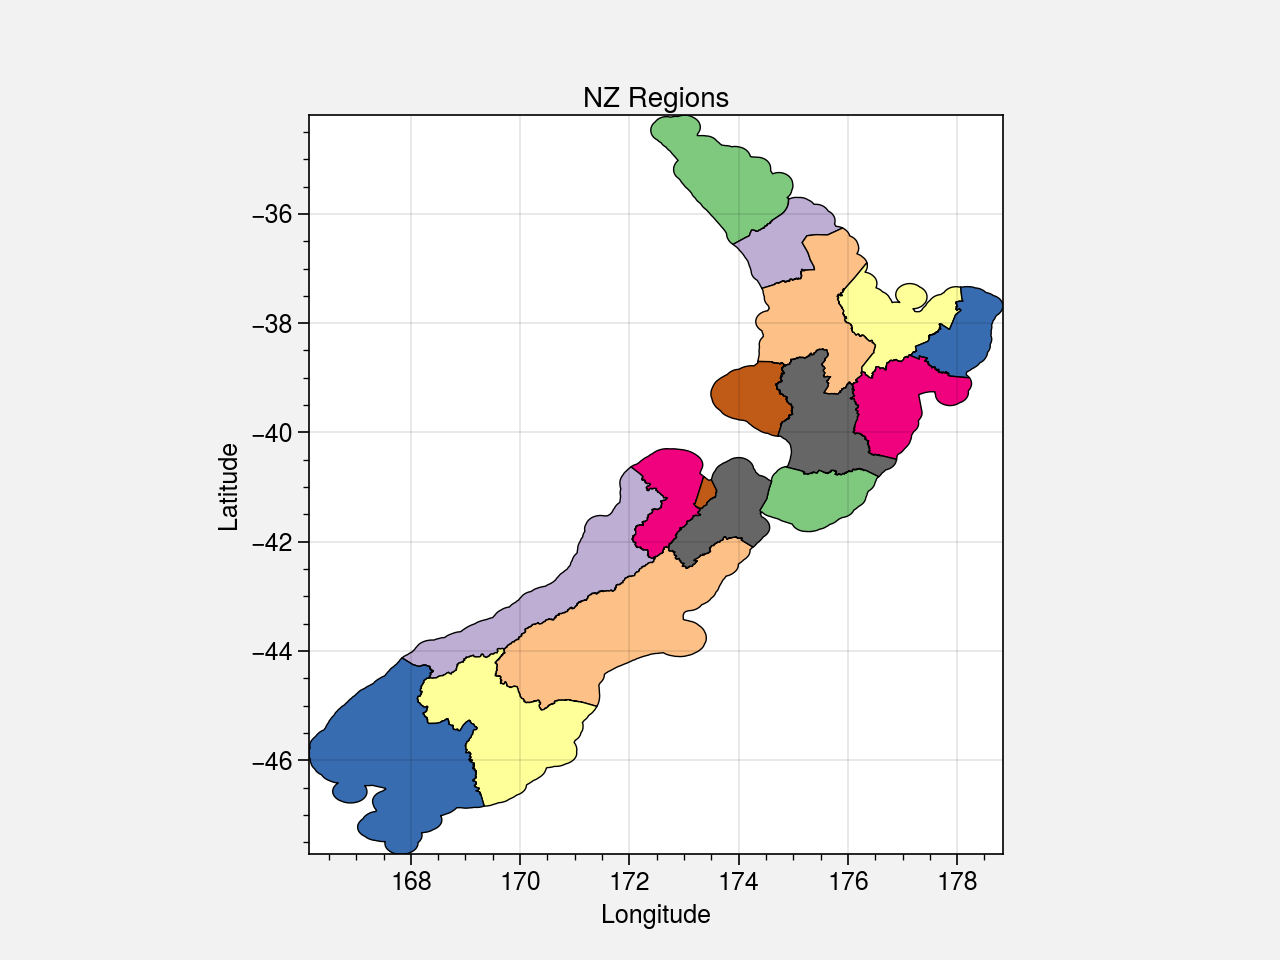

In [19]:
f, ax = plt.subplots()
nz_regions.plot(cmap=plt.cm.Accent, figsize=(10,15), lw=2, edgecolor="black", linewidth=.5, ax=ax)
ax.set_title('NZ Regions')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
f.savefig(HOME / 'research' / 'Smart_Ideas' / 'figures' / 'NZ_15_regions_loc.png', dpi=200, bbox_inches='tight')

### sanitize the names 

In [20]:
nz_regions.loc[:,'REGC2018_1'] = nz_regions.loc[:,'REGC2018_1'].str.replace(' Region','').str.replace("'",'').str.replace(' ','_')

### create the output folder if not existing 

In [21]:
opath_root = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'NZ_regions' / 'NZ_15_regions'

In [22]:
if not opath_root.exists(): 
    opath_root.mkdir(parents=True)

### defines the number of quantiles we want 

In [23]:
num_quantiles = 3

In [24]:
quant_values = np.linspace(0, 1, num_quantiles + 1, endpoint=True)

In [25]:
quant_values = quant_values[1:-1]

In [26]:
quant_values

array([0.33333333, 0.66666667])

In [27]:
col_labs = [f"Q{int(x)}" for x in (quant_values*100)]

In [28]:
col_labs

['Q33', 'Q66']

In [29]:
# f, axes = plt.subplots(nrows=3, ncols=2)
# axes = axes.flatten()

quantiles_dict = {}

for i, region_name in enumerate(nz_regions.loc[:,'REGC2018_1']): 
    
    shape = nz_regions.query(f"REGC2018_1 == '{region_name}'")
    
    region = dset.salem.subset(shape=shape)

    region = region.salem.roi(shape=shape, all_touched=True)
    
#     region[var_name].isel(time=0).plot(ax=axes[i])
    
    ts = region.mean(dim=['lat','lon'])
    
    ts_df = ts[var_name].to_dataframe()
            
    ts_series = ts_df.loc[:,var_name]
    
    ts_series_cat = []
    
    quantiles_list = []
    
    for month in range(1, 13):
        
        ts_series_m = ts_series[ts_series.index.month == month]
        
        clim = ts_series_m.loc['1981':'2010']
        
        quantiles = [clim.quantile(q=q) for q in quant_values.tolist()]
        
        quantiles_list.append(quantiles.copy())
        
        quantiles.insert(0, -np.inf)
        
        quantiles.append(np.inf)
        
        ts_series_m_cats = pd.cut(ts_series_m, quantiles, labels=list(range(1, num_quantiles + 1)))
        
        ts_series_cat.append(ts_series_m_cats)
        
        del(quantiles)
     
    quantiles_dict[region_name]  = np.array(quantiles_list)
    
    ts_series_cat = pd.concat(ts_series_cat, axis=0)
    
    ts_series_cat = ts_series_cat.sort_index()
    
    ts_df.loc[:,f'cat_{num_quantiles}'] = ts_series_cat
    
    ts_df.loc[:,'anomalies'] = ts_df.loc[:,var_name].groupby(ts_df.index.month).apply(demean)
    
    opath = opath_root / big_var / region_name 
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
        
    ts_df.to_csv(opath / f'TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms.csv')
    
    #descriptive statistics per quantile category 
    
    ts_df.groupby(ts_df.loc[:,f'cat_{num_quantiles}']).describe().to_csv(opath / f'descriptive_stats_{region_name}__{big_var}_{num_quantiles}.csv')
    
    print(f"region {region_name} processed for variable {big_var}")
    

region Northland processed for variable RAD
region Auckland processed for variable RAD
region Waikato processed for variable RAD
region Bay_of_Plenty processed for variable RAD
region Gisborne processed for variable RAD
region Hawkes_Bay processed for variable RAD
region Taranaki processed for variable RAD
region Manawatu-Wanganui processed for variable RAD
region Wellington processed for variable RAD
region West_Coast processed for variable RAD
region Canterbury processed for variable RAD
region Otago processed for variable RAD
region Southland processed for variable RAD
region Tasman processed for variable RAD
region Nelson processed for variable RAD
region Marlborough processed for variable RAD


### saves the climatological terciles calculated from the VCSN regional aggregates

In [30]:
quantiles_list = []
for region_name in nz_regions.loc[:,'REGC2018_1']: 
    df = pd.DataFrame(quantiles_dict[region_name])
    df.index = range(1, 13)
    df.index.name = 'season'
    df.columns = pd.MultiIndex.from_product([[region_name],col_labs])
    quantiles_list.append(df)

In [31]:
quantiles_df = pd.concat(quantiles_list, axis=1)

In [32]:
quantiles_df

Northland              Auckland               Waikato             \
              Q33        Q66        Q33        Q66        Q33        Q66   
season                                                                     
1       20.663740  21.212656  20.256165  21.845097  20.425301  21.600550   
2       20.294603  20.724896  20.113982  21.296532  20.425835  21.377016   
3       18.334375  19.025963  18.551103  19.508163  18.534392  19.188385   
4       15.006131  15.563398  15.065487  16.040138  15.195916  15.534124   
5       11.393145  11.970681  11.407900  12.284566  11.208754  11.821025   
6        8.799880   9.036213   8.446227   8.982111   8.151418   8.641281   
7        7.495414   7.890550   7.066766   7.665736   6.703756   7.093990   
8        8.005472   8.519393   7.728579   8.179217   7.090238   7.595303   
9       10.172037  10.695267   9.982872  10.363734   9.389730   9.762944   
10      13.196326  13.859008  13.161588  13.556023  12.339401  13.039823   
11      16.488030  17.035614  16.281458  16.913227  15.787821  16.593228   
12      19.134734  19.657450  18.888810  19.766438  18.589451  19.755868   

       Bay_of_Plenty              Gisborne             ...      Otago  \
                 Q33        Q66        Q33        Q66  ...        Q33   
season                                                 ...              
1          21.016595  22.012252  21.290071  22.261552  ...  20.670685   
2          20.874964  21.582768  20.825593  21.612813  ...  19.887439   
3          18.715515  19.418105  18.713831  19.170557  ...  17.728924   
4          15.340539  15.789159  14.969428  15.716033  ...  13.890374   
5          11.454709  11.886972  11.239604  11.590638  ...   9.634496   
6           8.299115   8.572105   8.179131   8.405870  ...   6.383074   
7           6.870430   7.130850   6.787816   6.952111  ...   4.944306   
8           7.365745   7.767720   7.389165   7.648497  ...   5.601068   
9           9.587890   9.982694   9.763315  10.150956  ...   8.067242   
10         12.847550  13.457895  13.408261  13.971033  ...  11.820824   
11         16.440711  17.136329  16.931250  17.574852  ...  15.893635   
12         19.322119  20.119337  19.821763  20.676162  ...  18.982730   

                   Southland                Tasman                Nelson  \
              Q66        Q33        Q66        Q33        Q66        Q33   
season                                                                     
1       21.514597  19.655592  20.442887  21.210806  22.263376  22.746648   
2       21.017526  19.295348  19.933071  20.902102  21.792567  22.391750   
3       18.197092  16.615007  17.075652  18.863827  19.726140  20.274391   
4       14.253225  12.607570  13.056404  14.982872  15.862038  16.191015   
5        9.825296   8.415422   8.821983  10.960980  11.461281  11.754322   
6        6.489532   5.458513   5.648472   7.504269   7.880965   8.109907   
7        5.099302   4.148327   4.320745   6.116240   6.362116   6.635980   
8        5.865881   4.862988   5.014584   6.624614   6.851734   7.205447   
9        8.351364   7.117991   7.480218   8.945806   9.371010   9.682940   
10      12.268029  10.876968  11.140249  12.443883  13.015925  13.260604   
11      16.476806  14.874270  15.404490  16.340142  17.253926  17.258240   
12      19.697474  18.202669  18.680025  19.385308  20.196238  20.562019   

                  Marlborough             
              Q66         Q33        Q66  
season                                    
1       23.706495   21.806316  23.021129  
2       23.310298   21.306169  22.193503  
3       20.907864   19.334546  19.949252  
4       16.758325   15.355144  15.843859  
5       12.233068   11.236248  11.538609  
6        8.624740    7.745591   8.011283  
7        6.849969    6.189628   6.402336  
8        7.450462    6.805579   7.007786  
9       10.148777    9.339270   9.736640  
10      13.917602   12.925198  13.554457  
11      18.339731   16.935819  17.589680  
12      21.827962   19.90557

In [33]:
quantiles_df.to_csv(opath.parent / f'Climatological_quantiles_{num_quantiles}_cat_{big_var}.csv')